In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
from __future__ import absolute_import, division, print_function

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
import scipy as sp
from scipy.optimize import minimize, Bounds

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import tensorflow as tf
import keras
from keras.layers import Dense, Input
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping


Bad key "text.kerning_factor" on line 4 in
/home/asuresh/programs/anaconda3/envs/DCTR/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution
Using TensorFlow backend.


In [3]:
# Global plot settings
from matplotlib import rc
import matplotlib.font_manager

rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

In [4]:
# Check Versions
print(tf.__version__)  # 1.15.0
print(keras.__version__)  # 2.2.4
print(sp.__version__)  # 1.5.2

1.15.0
2.2.4
1.5.2


# The SRGN fitting algorithm

The DCTR paper ([arXiv:1907.08209](https://arxiv.org/abs/1907.08209)) shows how a continuously parameterized NN used for reweighting:

$f(x,\theta)=\text{argmax}_{f'}(\sum_{i\in\bf{\theta}_0}\log f'(x_i,\theta)+\sum_{i\in\bf{\theta}}\log (1-f'(x_i,\theta)))$

can also be used for fitting:

$\theta^*=\text{argmax}_{\theta'}(\sum_{i\in\bf{\theta}_0}\log f(x_i,\theta')+\sum_{i\in\bf{\theta}}\log (1-f(x_i,\theta')))$

This works well when the reweighting and fitting happen on the same 'level'.  However, if the reweighting happens at generator-level (before detector simulation) while the fit happens in simulation (after the effects of the detector), this procedure will not work.  It works only if the reweighting and fitting both happen at simulation-level or both happen at generator-level.  This notebook illustrates the alternative SRGN procedure from [arXiv:2010.03569](https://arxiv.org/abs/2010.03569):

Let $x$ and $y$ denote the generator- and simulation-level events respectively. Suppose that $g$ is a neural network defined as follows:

$g_{\theta'}(y)=\text{argmax}_{g}\sum_{y_i\in\boldsymbol{\theta_?}}\log(g_{\theta'}(y_i))+
    \sum_{(x_i,y_i)\in\boldsymbol{\theta_0}}w_{\theta_0}(x_i,\theta')\log(1-g_{\theta'}(y_i))$

where $w_{\theta_0}(x,\theta') = f(x,\theta')/(1-f(x,\theta'))$ is a reweighting function learned at generator level (and $\theta_0$ denotes the nominal value of the parameter).  

Then, 

$\theta_{\text{SRGN}}^*\equiv\text{argmin}_{\theta'}\left[\Pr(g_{\theta_?}(y)>g_{\theta'}(y))\right]$

where the quantity in $[\cdot]$ is typically called the area under the receiver operating characteristic curve or AUC. We calculate the AUC between $g$’s predictions on events from the unknown sample and  $g$’s predictions on reweighted events from the synthetic sample; effectively, if we reweight events from the synthetic sample $\boldsymbol{\theta_0}$ to events from $\boldsymbol{\theta’}$, then we calculate the AUC between $g$’s predictions on  $\boldsymbol{\theta_?} $and $g$’s predictions on $\boldsymbol{\theta’}$.


The intuition of the above equation is that the classifier $g$ is trying to distinguish events from the unknown sample $\boldsymbol{\theta_?}$ and events from $\boldsymbol{\theta'}$ and we try to find a $\theta'$ that makes $g$'s task maximally hard.  If $g$ can't tell apart the two samples (i.e. the AUC is minimized), then the reweighting has worked! Asympotitically, the SRGN method learns the same result as the one in the body of the DCTR paper: $\theta^*=\theta_?$.

# One-dimensional Gaussian Example 
In this notebook, we apply the SRGN fitting algorithm to a simple one-dimensional example: fitting the mean $\mu$ of a Gaussian distribution. 

## Training a DCTR Model
First, we need to train a DCTR model parameterized by $\mu$ to provide us with a reweighting function to be used during fitting.

In [5]:
n_data_points = 10**7

mu_min, mu_max = -2, 2

### Generate training & validation data

In [6]:
mu0, sigma0 = 0, 1  # nominal values for mu and sigma
mu_values = np.random.uniform(mu_min, mu_max, n_data_points)

X0 = [(np.random.normal(mu0, sigma0), mu) for mu in mu_values]
X1 = [(np.random.normal(mu, sigma0), mu) for mu in mu_values]

Y0 = to_categorical(np.zeros(n_data_points), num_classes=2)
Y1 = to_categorical(np.ones(n_data_points), num_classes=2)

X = np.concatenate((X0, X1))
Y = np.concatenate((Y0, Y1))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)

### Build Model

In [7]:
inputs = Input((2, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(2, activation='softmax')(hidden_layer_3)

dctr_model = Model(inputs=inputs, outputs=outputs)
dctr_model.compile(loss='categorical_crossentropy',
                   optimizer='Adam',
                   metrics=['accuracy'])

### Train Model

In [8]:
earlystopping = EarlyStopping(patience=10,
                              verbose=1,
                              restore_best_weights=True)
dctr_model.fit(X_train,
               Y_train,
               epochs=200,
               batch_size=10000,
               validation_data=(X_test, Y_test),
               callbacks=[earlystopping],
               verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 10000000 samples, validate on 10000000 samples
Epoch 1/200





10000000/10000000 [==============================] - 38s 4us/step - loss: 0.5662 - acc: 0.6826 - val_loss: 0.5628 - val_acc: 0.6843
Epoch 2/200
10000000/10000000 [==============================] - 36s 4us/step - loss: 0.5631 - acc: 0.6840 - val_loss: 0.5631 - val_acc: 0.6841
Epoch 3/200
10000000/10000000 [==============================] - 36s 4us/step - loss: 0.5630 - acc: 0.6839 - val_loss: 0.5627 - val_acc: 0.6843
Epoch 4/200
10000000/10000000 [==============================] - 37s 4us/step - loss: 0.5630 - acc: 0.6840 - val_loss: 0.5627 - val_acc: 0.6843
Epoch 5/200
10000000/10000000 [==============================] - 36s 4us/step - loss: 0.5630 - acc: 0.6841 - val_loss: 0.5627 - val_acc: 0.6844
Epoch 6/200
10000000/10000000 [==============================] - 70s 7us/step - loss: 0.5630 - acc: 0.6840 - val_loss: 0.5

### Defining reweighting functions

$w_{\theta_0}(x_{G,i},\theta)=\frac{f(x_{G,i}\theta)}{1-f(x_{G,i},\theta)}$, where $f$  is a fully trained DCTR model.

Takes generator-level event $x_{G,i}$ from the synthetic sample $\boldsymbol{\theta_0}$ and weights it to an event from $\boldsymbol{\theta}$.

The expression for the analytical reweighting function for the Gaussian distribution (at fixed $\sigma=1$) is:

$w_{\mu_0}(x_{G,i}, \mu) = \exp{(\frac{1}{2}((x_{G,i}-\mu_0)^2-(x_{G,i}-\mu)^2))}$.

In [9]:
# from NN (DCTR)
def reweight(events, param):
    # creating array with same length as inputs, with theta_prime in every entry
    concat_input_and_params = np.ones(shape=events.shape) * param
    # combining and reshaping into correct format:
    model_inputs = np.concatenate((events, concat_input_and_params), axis=-1)

    f = dctr_model.predict(model_inputs, batch_size=10000)
    weights = (f[:, 1]) / (f[:, 0])
    return weights


# from analytical formula for normal distributions
def analytical_reweight(events, param, param0=mu0):
    weights = np.exp(0.5 * ((events - param0)**2 - (events - param)**2))
    return weights

## Validate DCTR for any $\mu$

In [10]:
# Define default plot styles
plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': True
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': True
}

plot_style_2 = {'alpha': 0.5, 'density': True}

### Validate for Generator-level

In [11]:
mu1 = 1.5
assert mu1 >= mu_min and mu1 <= mu_max  # choose mu1 in valid range
X0_val_G = np.random.normal(mu0, 1, 10**6)
X1_val_G = np.random.normal(mu1, 1, 10**6)

In [12]:
weights = reweight(np.expand_dims(X0_val_G, axis=-1), mu1)
analytical_weights = analytical_reweight(X0_val_G, mu1)

#### Generator-level Reweighting

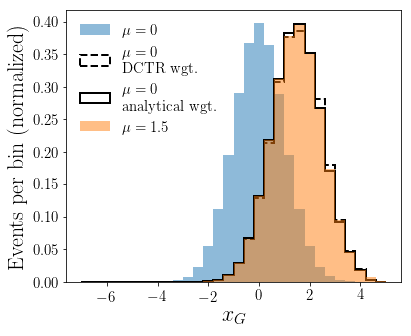

In [13]:
bins = np.linspace(-7, 5, 31)
plt.figure(figsize=(6, 5))
hist0 = plt.hist(X0_val_G,
                 bins=bins,
                 label=r'$\mu={}$'.format(mu0),
                 **plot_style_2)
hist1 = plt.hist(X0_val_G,
                 bins=bins,
                 label='$\mu={}$\nDCTR wgt.'.format(mu0),
                 weights=weights,
                 **plot_style_0)
hist2 = plt.hist(X0_val_G,
                 bins=bins,
                 label='$\mu={}$\nanalytical wgt.'.format(mu0),
                 weights=analytical_weights,
                 **plot_style_1)
hist3 = plt.hist(X1_val_G,
                 bins=bins,
                 label=r'$\mu={}$'.format(mu1),
                 **plot_style_2)
plt.legend(frameon=False)
plt.xlabel(r"$x_G$")
plt.ylabel("Events per bin (normalized)")
plt.show()

### Validate for Simulation-level

#### Detector Smearing

To apply detector effects, each generator-level event $x_{G,i}$in the sample is smeared by shifting by $Z_{i}\sim\mathcal{N}(0,\epsilon^2)$,where $\epsilon$ represents the smearing (i.e. the simulation-level event $x_{S,i} = x_{G,i} + Z_{i}$)

In [14]:
# Generate simulation-level by smearing truth

epsilon_val = 0.5  # Smearing width

X0_val_S = np.array([(x + np.random.normal(0, epsilon_val))
                     for x in X0_val_G])  # Detector smearing
X1_val_S = np.array([(x + np.random.normal(0, epsilon_val))
                     for x in X1_val_G])  # Detector smearing

No handles with labels found to put in legend.
No handles with labels found to put in legend.


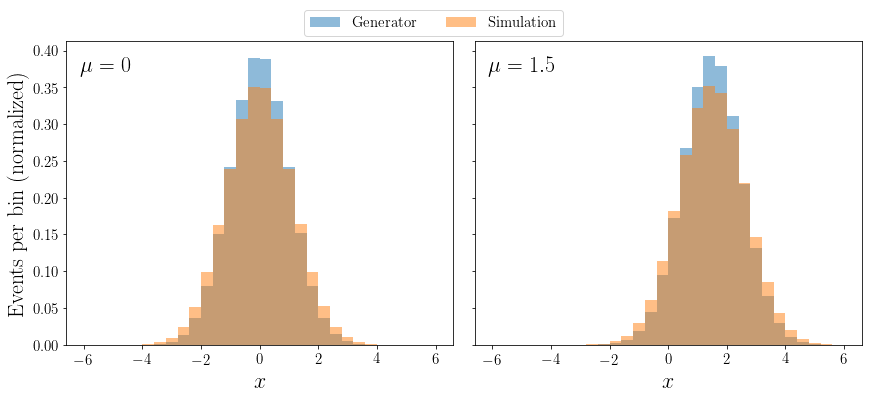

In [15]:
fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

bins = np.linspace(-6, 6, 31)

ax[0].set_xlabel("$x$")
ax[0].set_ylabel('Events per bin (normalized)')
ax[0].hist(X0_val_G, bins=bins, **plot_style_2)
ax[0].hist(X0_val_S, bins=bins, **plot_style_2)
ax[0].legend(title=r'$\mu={}$'.format(mu0), loc='upper left', frameon=False)

ax[1].set_xlabel("$x$")
ax[1].hist(X1_val_G, bins=bins, **plot_style_2)
ax[1].hist(X1_val_S, bins=bins, **plot_style_2)
ax[1].legend(title=r'$\mu={}$'.format(mu1), loc='upper left', frameon=False)

handles = [Patch(facecolor='C0', alpha=0.5), Patch(facecolor='C1', alpha=0.5)]
labels = ['Generator', 'Simulation']
fig.legend(handles, labels, ncol=2, bbox_to_anchor=(0.66, 1.1))

fig.show()

#### Simulation-level Reweighting

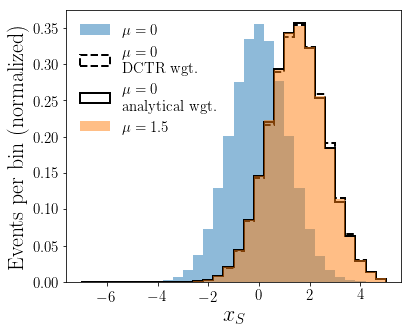

In [16]:
bins = np.linspace(-7, 5, 31)
plt.figure(figsize=(6, 5))
hist0 = plt.hist(X0_val_S,
                 bins=bins,
                 label=r'$\mu={}$'.format(mu0),
                 **plot_style_2)
hist1 = plt.hist(X0_val_S,
                 bins=bins,
                 label='$\mu={}$\nDCTR wgt.'.format(mu0),
                 weights=weights,
                 **plot_style_0)
hist2 = plt.hist(X0_val_S,
                 bins=bins,
                 label='$\mu={}$\nanalytical wgt.'.format(mu0),
                 weights=analytical_weights,
                 **plot_style_1)
hist3 = plt.hist(X1_val_S,
                 bins=bins,
                 label=r'$\mu={}$'.format(mu1),
                 **plot_style_2)
plt.legend(frameon=False)
plt.xlabel(r"$x_S$")
plt.ylabel("Events per bin (normalized)")
plt.show()

# Fitting

## Setup the dataset

$\boldsymbol{\theta_0}$ denotes the synthetic sample used for reweighting, and we are trying to fit the parameter $\theta$ (in this case $\mu$) to the 'data' sample $\boldsymbol{\theta_?}$ (`theta_unknown`).

Again, to apply detector effects, each generator-level event $x_{G,i}$in the samples is smeared by shifting by $Z_{i}\sim\mathcal{N}(0,\epsilon^2)$,where $\epsilon$ represents the smearing (i.e. the simulation-level event $x_{S,i} = x_{G,i} + Z_{i}$)

In [17]:
N = 10**6
theta0_param = mu0  # synthetic sample
theta_unknown_param = 1  # this is the data (the target)
sigma = sigma0  # standard Gaussian width
epsilon = sigma / 2  # Smearing width

theta0_G = np.random.normal(theta0_param, sigma,
                            N)  # Generator-level synthetic sample
theta0_S = np.array([(x + np.random.normal(0, epsilon)) for x in theta0_G
                     ])  # Detector smearing for synthetic sample
theta0 = np.stack([theta0_G, theta0_S], axis=1)

theta_unknown_G = np.random.normal(theta_unknown_param, sigma, N)
theta_unknown_S = np.array([(x + np.random.normal(0, epsilon))
                            for x in theta_unknown_G])
theta_unknown = np.stack([theta_unknown_G, theta_unknown_S], axis=1)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


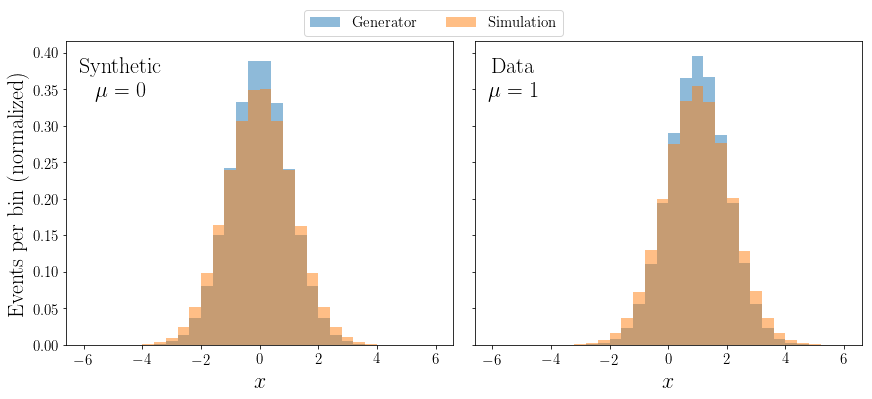

In [18]:
bins = np.linspace(-6, 6, 31)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel('$x$')
ax[0].set_ylabel('Events per bin (normalized)')
ax[0].hist(theta0_G, bins=bins, **plot_style_2)
ax[0].hist(theta0_S, bins=bins, **plot_style_2)
legend = ax[0].legend(title='Synthetic\n$\mu={}$'.format(theta0_param),
                      loc='upper left',
                      frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x$')
ax[1].hist(theta_unknown_G, bins=bins, **plot_style_2)
ax[1].hist(theta_unknown_S, bins=bins, **plot_style_2)
legend = ax[1].legend(title='Data\n$\mu={}$'.format(theta_unknown_param),
                      loc='upper left',
                      frameon=False)
plt.setp(legend.get_title(), multialignment='center')

handles = [Patch(facecolor='C0', alpha=0.5), Patch(facecolor='C1', alpha=0.5)]
labels = ['Generator', 'Simulation']
fig.legend(handles, labels, ncol=2, bbox_to_anchor=(0.66, 1.1))

fig.show()

In [19]:
labels0 = np.zeros(len(theta0))
labels_unknown = np.ones(len(theta_unknown))

xvals = np.concatenate([theta0, theta_unknown])
yvals = np.concatenate([labels0, labels_unknown])

X_train, X_test, Y_train, Y_test = train_test_split(xvals,
                                                    yvals,
                                                    test_size=0.5)

X_train_G, Y_train_G = X_train[:, 0], Y_train
X_test_G, Y_test_G = X_test[:, 0], Y_test

X_train_S, Y_train_S = X_train[:, 1], Y_train
X_test_S, Y_test_S = X_test[:, 1], Y_test

## Fitting Model: Scan

We'll start by showing that for fixed $\theta$, the AUC is minimized when $\theta=\theta_?$.

### Creating Model

In [20]:
myinputs = Input(shape=(1, ), dtype=tf.float32)
x = Dense(128, activation='relu')(myinputs)
x2 = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x2)

model = Model(inputs=myinputs, outputs=predictions)
model.summary()

batch_size = 1000
earlystopping = EarlyStopping(patience=5, restore_best_weights=True)

# scanning range for theta
thetas = np.linspace(mu_min, mu_max, 21)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               256       
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 16,897
Trainable params: 16,897
Non-trainable params: 0
_________________________________________________________________


We will train this model with a weighted binary cross-entropy loss function:

$\text{loss}(g_{\theta'}(x))=-\sum_{x_i\in\boldsymbol{\theta_?}}\log(g_{\theta'}(x_i))-
    \sum_{x_i\in\boldsymbol{\theta_0}}w_{\theta_0}(x_{G,i},\theta')\log(1-g_{\theta'}(x_i))$
    
where $x_i=x_{G,i}$ when fitting on generator-level and $x_i=x_{S,i}$ when fitting on simulation-level. Note that reweighting always occurs on generator-level, as we always know the generator-level events for the synthetic sample (but not necessarily for the data).

### Generator-level Scan

Here, we actually know the generator-level events for both the synthetic sample and data.

In [21]:
def run_classifier_G(theta, reweight_type='DCTR'):

    weights_train = np.ones(len(X_train_G))
    weights_test = np.ones(len(X_test_G))

    # calculate weights for events in theta_0, but leave ones for events in theta_?
    if reweight_type == 'DCTR':
        weights_train[Y_train_G == 0] = reweight(
            np.expand_dims(X_train_G[Y_train_G == 0], axis=-1), theta)
        weights_test[Y_test_G == 0] = reweight(
            np.expand_dims(X_test_G[Y_test_G == 0], axis=-1), theta)
    elif reweight_type == 'analytical':
        weights_train[Y_train_G == 0] = analytical_reweight(
            X_train_G[Y_train_G == 0], theta)
        weights_test[Y_test_G == 0] = analytical_reweight(
            X_test_G[Y_test_G == 0], theta)
    else:
        raise ValueError("reweight_type must be set to 'DCTR' or 'analytical'")

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # fit model on weighted binary cross-entropy
    history = model.fit(X_train_G,
                        Y_train_G,
                        sample_weight=weights_train,
                        epochs=200,
                        batch_size=batch_size,
                        validation_data=(X_test_G, Y_test_G, weights_test),
                        verbose=0,
                        callbacks=[earlystopping])

    # after training, calculate AUC between unknown sample and reweighted synthetic sample
    auc = roc_auc_score(np.concatenate((Y_train_G, Y_test_G)),
                        model.predict(np.concatenate((X_train_G, X_test_G)),
                                      batch_size=1000),
                        sample_weight=np.concatenate(
                            (weights_train, weights_test)))

    return auc

In [22]:
AUC_G = []

for theta in thetas:
    print("Testing theta = {:.1f}".format(theta))

    auc = run_classifier_G(theta)
    AUC_G += [auc]

    print("AUC: {:.2f}".format(auc))
    print("\n")
    pass

Testing theta = -2.0
AUC: 0.98


Testing theta = -1.8
AUC: 0.98


Testing theta = -1.6
AUC: 0.97


Testing theta = -1.4
AUC: 0.96


Testing theta = -1.2
AUC: 0.94


Testing theta = -1.0
AUC: 0.92


Testing theta = -0.8
AUC: 0.90


Testing theta = -0.6
AUC: 0.87


Testing theta = -0.4
AUC: 0.84


Testing theta = -0.2
AUC: 0.80


Testing theta = 0.0
AUC: 0.76


Testing theta = 0.2
AUC: 0.72


Testing theta = 0.4
AUC: 0.67


Testing theta = 0.6
AUC: 0.61


Testing theta = 0.8
AUC: 0.56


Testing theta = 1.0
AUC: 0.50


Testing theta = 1.2
AUC: 0.56


Testing theta = 1.4
AUC: 0.62


Testing theta = 1.6
AUC: 0.67


Testing theta = 1.8
AUC: 0.72


Testing theta = 2.0
AUC: 0.76




### Simulation-level Scan
Here, we only know the generator-level events for the synthetic sample and the simulation-level events for both samples. Thus, we reweight on the generator-level events, but classify between the simulation-level events.

In [23]:
def run_classifier_S(theta, reweight_type='DCTR'):

    weights_train = np.ones(len(X_train_G))
    weights_test = np.ones(len(X_test_G))

    # calculate weights for events in theta_0, but leave ones for events in theta_?
    if reweight_type == 'DCTR':
        weights_train[Y_train_G == 0] = reweight(
            np.expand_dims(X_train_G[Y_train_G == 0], axis=-1), theta)
        weights_test[Y_test_G == 0] = reweight(
            np.expand_dims(X_test_G[Y_test_G == 0], axis=-1), theta)
    elif reweight_type == 'analytical':
        weights_train[Y_train_G == 0] = analytical_reweight(
            X_train_G[Y_train_G == 0], theta)
        weights_test[Y_test_G == 0] = analytical_reweight(
            X_test_G[Y_test_G == 0], theta)
    else:
        raise ValueError("reweight_type must be set to 'DCTR' or 'analytical'")

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # fit model on weighted binary cross-entropy
    history = model.fit(X_train_S,
                        Y_train_S,
                        sample_weight=weights_train,
                        epochs=200,
                        batch_size=batch_size,
                        validation_data=(X_test_S, Y_test_S, weights_test),
                        verbose=0,
                        callbacks=[earlystopping])

    # after training, calculate AUC between unknown sample and reweighted synthetic sample
    auc = roc_auc_score(np.concatenate((Y_train_S, Y_test_S)),
                        model.predict(np.concatenate((X_train_S, X_test_S)),
                                      batch_size=10000),
                        sample_weight=np.concatenate(
                            (weights_train, weights_test)))

    return auc

In [24]:
AUC_S = []

for theta in thetas:
    print("Testing theta = {:.1f}".format(theta))

    auc = run_classifier_S(theta)
    AUC_S += [auc]

    print("AUC: {:.2f}".format(auc))
    print("\n")
    pass

Testing theta = -2.0
AUC: 0.97


Testing theta = -1.8
AUC: 0.96


Testing theta = -1.6
AUC: 0.95


Testing theta = -1.4
AUC: 0.94


Testing theta = -1.2
AUC: 0.92


Testing theta = -1.0
AUC: 0.90


Testing theta = -0.8
AUC: 0.87


Testing theta = -0.6
AUC: 0.84


Testing theta = -0.4
AUC: 0.81


Testing theta = -0.2
AUC: 0.78


Testing theta = 0.0
AUC: 0.74


Testing theta = 0.2
AUC: 0.70


Testing theta = 0.4
AUC: 0.65


Testing theta = 0.6
AUC: 0.60


Testing theta = 0.8
AUC: 0.55


Testing theta = 1.0
AUC: 0.50


Testing theta = 1.2
AUC: 0.55


Testing theta = 1.4
AUC: 0.61


Testing theta = 1.6
AUC: 0.65


Testing theta = 1.8
AUC: 0.70


Testing theta = 2.0
AUC: 0.74




### Scan results

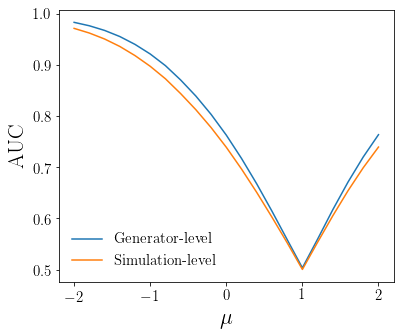

In [25]:
plt.figure(figsize=(6, 5))
plt.plot(thetas, AUC_G, label='Generator-level')
plt.plot(thetas, AUC_S, label='Simulation-level')
plt.xlabel(r'$\mu$')
plt.ylabel('AUC')
plt.legend(loc='lower left', frameon=False)
plt.show()

We've shown for fixed $\theta$, the AUC is minimized $\theta=\theta_?$. Additionally, the rise in the AUC function away from the minimum is steeper at generator-level than simulation-level, as expected given the loss of statistical power from detector smearing.

## Fitting Model: Non-Gradient Fit
Since the AUC is non-differentiable, let's use a non-gradient optimizer to minimize it.

In [26]:
# restrict optimization to bounds of parameterization of the reweighting function
mybounds = Bounds(np.array([mu_min]), np.array([mu_max]))

theta0 = np.array([0.])  # initialize

### Generator-level Fit

In [27]:
def get_AUC_G(x):
    theta_prime = x[0]
    AUC_G = run_classifier_G(theta_prime)
    return AUC_G

In [28]:
res_G = minimize(get_AUC_G,
                 theta0,
                 method="Powell",
                 bounds=mybounds,
                 options={
                     'maxiter': 100,
                     'disp': True,
                     'return_all': True
                 })

Optimization terminated successfully.
         Current function value: 0.499746
         Iterations: 3
         Function evaluations: 103


In [29]:
print('Optimizer fit value at generator-level: theta_SRGN = {:.3f}.'.format(
    res_G['x'][0]))

Optimizer fit value at generator-level: theta_SRGN = 1.000.


### Simulation-level Fit

In [30]:
def get_AUC_S(x):
    theta_prime = x[0]
    AUC_S = run_classifier_S(theta_prime)
    return AUC_S

In [31]:
res_S = minimize(get_AUC_S,
                 theta0,
                 method="Powell",
                 bounds=mybounds,
                 options={
                     'maxiter': 100,
                     'disp': True,
                     'return_all': True
                 })

Optimization terminated successfully.
         Current function value: 0.499961
         Iterations: 2
         Function evaluations: 74


In [32]:
print('Optimizer fit value at simulation-level: theta_SRGN = {:.3f}.'.format(
    res_S['x'][0]))

Optimizer fit value at simulation-level: theta_SRGN = 1.000.
